In [2]:
%load_ext autoreload
%autoreload 2

from computage.deage.kdm import KlemeraDoubalEstimator
from computage.deage.pls import PLS1
from computage.utils.data_utils import test_dataset
from computage.utils.metric_utils import print_metrics
from computage.analyzer.timecourse import linear_time_analysis
import pickle
from biolearn.model_gallery import ModelGallery

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
gallery = ModelGallery()
list(gallery.model_definitions.keys())
k1 = 'HRSInCHPhenoAge'
k2 = 'PhenoAge'

indices = gallery.get(k1).clock.coefficients.index

In [3]:
# data, meta = pd.read_pickle('/tank/projects/computage/train/GSE40279.pkl.gz', compression='gzip').values()
# data, meta = pd.read_pickle('/tank/projects/computage/train/ultra_train_v1.pkl',).values()
data, meta = pd.read_pickle(f'/tank/projects/computage/train/ultra_train_v1_cut400k.pkl').values()

# Explore Stats

In [4]:
# stats = pd.read_csv('/tank/projects/computage/train/train_stats/GSE40279_corrstats.csv', index_col=0)

In [7]:
_data = pd.DataFrame({'r_abs':np.abs(stats['rvalue']), 
                      'r_res_abs':np.abs(stats['r_res']), 
                      'pheno':stats.index.isin(indices),
                      })


<Axes: xlabel='age', ylabel='cg09035930'>

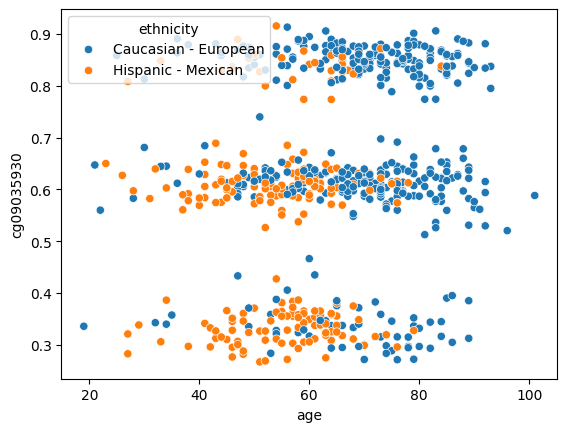

In [49]:
sns.scatterplot(x=meta['age'], y=data['cg09035930'], hue=meta['ethnicity'])

In [45]:
stats.loc[indices]['rse'].sort_values()

CpGmarker
cg00770871    0.002671
cg17414580    0.002994
cg16209630    0.003497
cg03970588    0.003731
cg04794120    0.004187
                ...   
cg09035930    0.185603
cg16744531    0.204931
cg06223162    0.216534
cg13077366    0.229496
cg04131969    0.314435
Name: rse, Length: 959, dtype: float64

<Axes: >

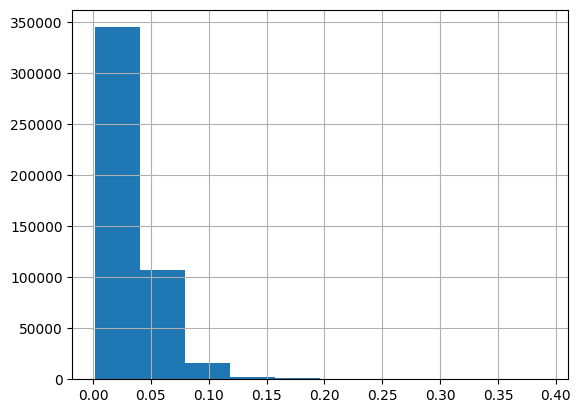

In [41]:
stats['rse'].hist()

In [38]:
stats.sort_values('r_res')

,slope,intercept,rvalue,p-value,stderr,rse,r2,s_res,i_res,r_res,p_res
id,,,,,,,,,,,
cg23556238,0.003138,0.585187,0.300316,3.862910e-15,0.000390,0.146992,0.090190,-0.003873,0.347613,-0.529114,1.330739e-48
cg11422312,0.002909,0.591980,0.287277,6.258603e-14,0.000379,0.143039,0.082528,-0.003718,0.330531,-0.502971,2.345663e-43
cg09651654,0.005226,0.488881,0.310976,3.559654e-16,0.000625,0.235537,0.096706,-0.005133,0.499299,-0.466971,7.757251e-37
cg07646083,0.003440,0.571996,0.249952,8.412544e-11,0.000521,0.196516,0.062476,-0.004219,0.412190,-0.458832,1.816157e-35
cg05526809,0.004262,0.491666,0.271115,1.624849e-12,0.000592,0.223147,0.073503,-0.004271,0.448073,-0.454380,9.837368e-35
...,...,...,...,...,...,...,...,...,...,...,...
cg16204205,-0.000119,0.794138,-0.030713,4.322668e-01,0.000151,0.056932,0.000943,0.000957,-0.020068,0.359893,1.714384e-21
cg26128129,-0.002497,0.958852,-0.196029,4.184137e-07,0.000488,0.184210,0.038427,0.002737,-0.026383,0.373066,4.313464e-23
cg04457792,0.000462,0.288257,0.131762,7.167579e-04,0.000136,0.051210,0.017361,0.000902,-0.020756,0.376700,1.515267e-23


<Axes: xlabel='r_res_abs', ylabel='Density'>

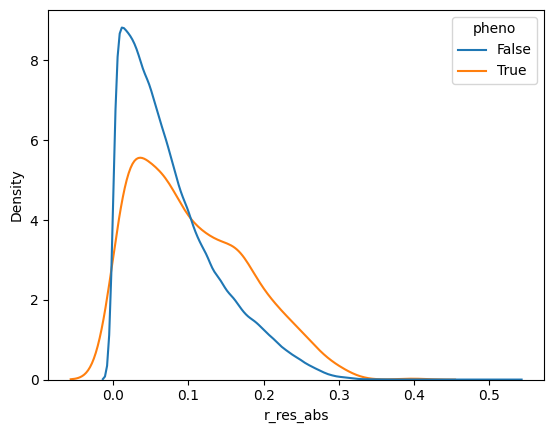

In [14]:
sns.kdeplot(data=_data, x='r_res_abs', hue='pheno', common_norm=False)

<Axes: xlabel='r_abs', ylabel='Density'>

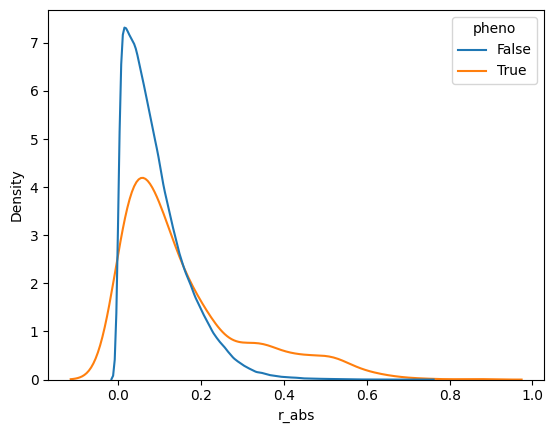

In [15]:
sns.kdeplot(data=_data, x='r_abs', hue='pheno', common_norm=False)

<Axes: xlabel='r_abs', ylabel='r_res_abs'>

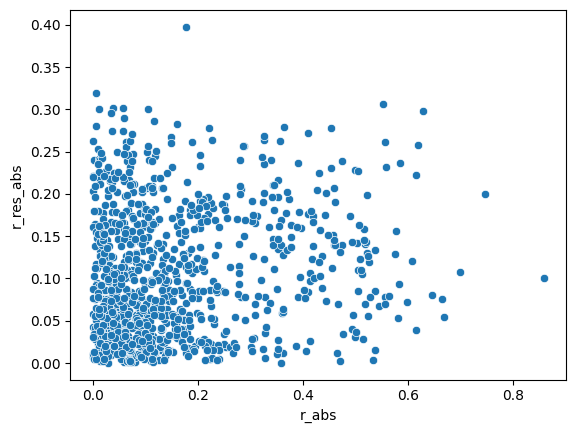

In [16]:
sns.scatterplot(data=_data[_data['pheno'] == True], x='r_abs', y='r_res_abs')

# Create stats

<Axes: >

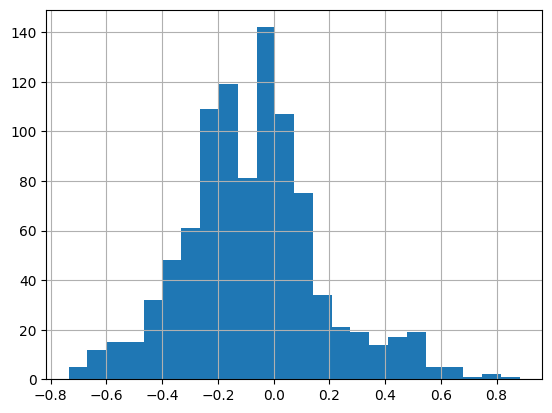

In [5]:
corrcoef = data[indices].corrwith(meta['Age'])
corrcoef.hist(bins=24)

In [7]:
topsites = corrcoef.abs().sort_values(ascending=False)[:].index

In [15]:
#filtering dataset
site_sum = data.isna().sum(axis=0)
s = site_sum / data.shape[0] < 0.2
filt_indices = meta[(meta['Condition'] == 'HC') & (meta['Age'] > 20.0) & (meta['Age'] < 80.0)].index
data_selected = data.loc[filt_indices, s[s].index]
meta_selected = meta.loc[filt_indices]
y = meta_selected['Age']

In [16]:
train_dataset = {}
train_dataset['data'] = data_selected
train_dataset['meta'] = meta_selected
# pd.to_pickle(train_dataset, f'/tank/projects/computage/train/ultra_train_v1.pkl.gz', compression='gzip')
pd.to_pickle(train_dataset, f'/tank/projects/computage/train/ultra_train_v1_cut400k.pkl')

In [4]:
stats = linear_time_analysis(data, meta['Age'])

In [5]:
stats.to_csv('/tank/projects/computage/train/train_stats/ultra_train_v1_corrstats.csv')

In [6]:
stats

,slope,intercept,rvalue,p-value,stderr,rse,r2,s_res,i_res,r_res,p_res
cg00000029,-0.001267,0.583750,-0.224625,3.894478e-55,0.000080,0.062649,0.050456,-0.000256,0.059578,-0.069687,1.620420e-06
cg00000108,0.000037,0.941572,0.019588,2.165993e-01,0.000030,0.020420,0.000384,-0.000049,0.015873,-0.034426,2.985067e-02
cg00000109,-0.000704,0.934216,-0.184614,1.246231e-37,0.000054,0.042782,0.034082,-0.000470,0.057944,-0.208730,7.633817e-48
cg00000165,0.001049,0.133974,0.219277,7.100787e-53,0.000068,0.053272,0.048082,-0.000388,0.060239,-0.128459,5.919071e-19
cg00000236,-0.000510,0.788847,-0.117931,3.345277e-16,0.000062,0.049027,0.013908,-0.000376,0.056783,-0.137309,1.852941e-21
...,...,...,...,...,...,...,...,...,...,...,...
cg26819762,-0.000980,0.937809,-0.189660,7.436142e-35,0.000079,0.054033,0.035971,-0.000584,0.072825,-0.198901,3.128058e-38
cg27229823,-0.000863,0.963408,-0.182997,2.986539e-32,0.000072,0.049412,0.033488,-0.000304,0.054421,-0.109087,2.401815e-12
cg27453745,0.000819,0.032092,0.287542,5.719821e-77,0.000043,0.029438,0.082681,-0.000210,0.033153,-0.121520,1.259408e-14
ch.11.87583764F,0.000271,0.015400,0.180652,1.305293e-30,0.000023,0.015921,0.032635,-0.000114,0.018460,-0.130490,1.290997e-16


In [7]:
#stats['fi'] = np.abs(stats['rvalue'])**2 / stats['rse']**2 * stats['r_res']**2
stats['fi'] = np.abs(stats['rvalue'])**2 * stats['r_res']**2

stats.sort_values('fi', ascending=False).head(7)

,slope,intercept,rvalue,p-value,stderr,rse,r2,s_res,i_res,r_res,p_res,fi
cg05412028,-0.002756,0.237389,-0.558547,0.000000e+00,0.000059,0.046706,0.311974,-0.000740,0.073167,-0.281079,8.696198e-87,0.024648
cg22353329,0.002569,0.096746,0.415620,4.349684e-198,0.000082,0.064129,0.172740,-0.001329,0.115444,-0.359075,9.509110e-145,0.022272
cg14361627,0.002660,0.060500,0.672214,0.000000e+00,0.000047,0.031834,0.451872,0.000410,0.002840,0.216869,9.785804e-42,0.021253
cg04105760,0.003543,0.152383,0.313830,4.345284e-105,0.000159,0.123757,0.098489,-0.003214,0.255359,-0.448814,1.264046e-225,0.019839
cg19499748,0.002534,0.114996,0.330928,2.660904e-117,0.000107,0.083417,0.109513,-0.002072,0.166849,-0.425123,3.815167e-200,0.019792
cg10506618,0.006512,0.474105,0.299220,3.586803e-95,0.000307,0.239772,0.089533,-0.006592,0.510018,-0.464752,1.069077e-243,0.019339
cg13649056,0.002630,0.082669,0.543301,0.000000e+00,0.000060,0.046908,0.295176,-0.000657,0.069732,-0.255866,2.763550e-69,0.019324


(-0.35, 0.35)

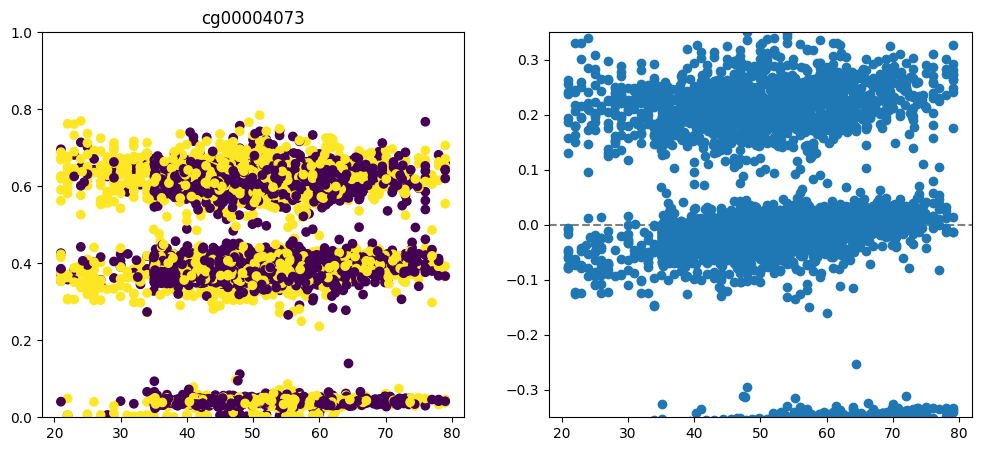

In [42]:
site = 'cg00004073'
y = meta['Age']
fig, axes = plt.subplots(1, 2, figsize=(12,5))
resid = data[site] - stats.loc[site, 'slope'] * y - stats.loc[site, 'intercept']

axes[0].scatter(y, data[site], c=meta['Gender'].map({'M':0, 'F':1}))
axes[0].set_ylim([0, 1])
axes[0].set_title(site)
axes[1].axhline(0, color='grey', ls='--', zorder=0)
axes[1].scatter(y, resid)
axes[1].set_ylim([-0.35, 0.35])


In [24]:
topsites = stats.iloc[:500].index

In [34]:
sex = meta['Gender'].map({'M':0, 'F':1})

GSM989827     F
GSM989829     F
GSM989830     F
GSM989831     F
GSM989833     M
             ..
GSM1696559    F
GSM1696560    F
GSM1696561    F
GSM1696562    F
GSM1696563    F
Name: Gender, Length: 4758, dtype: object

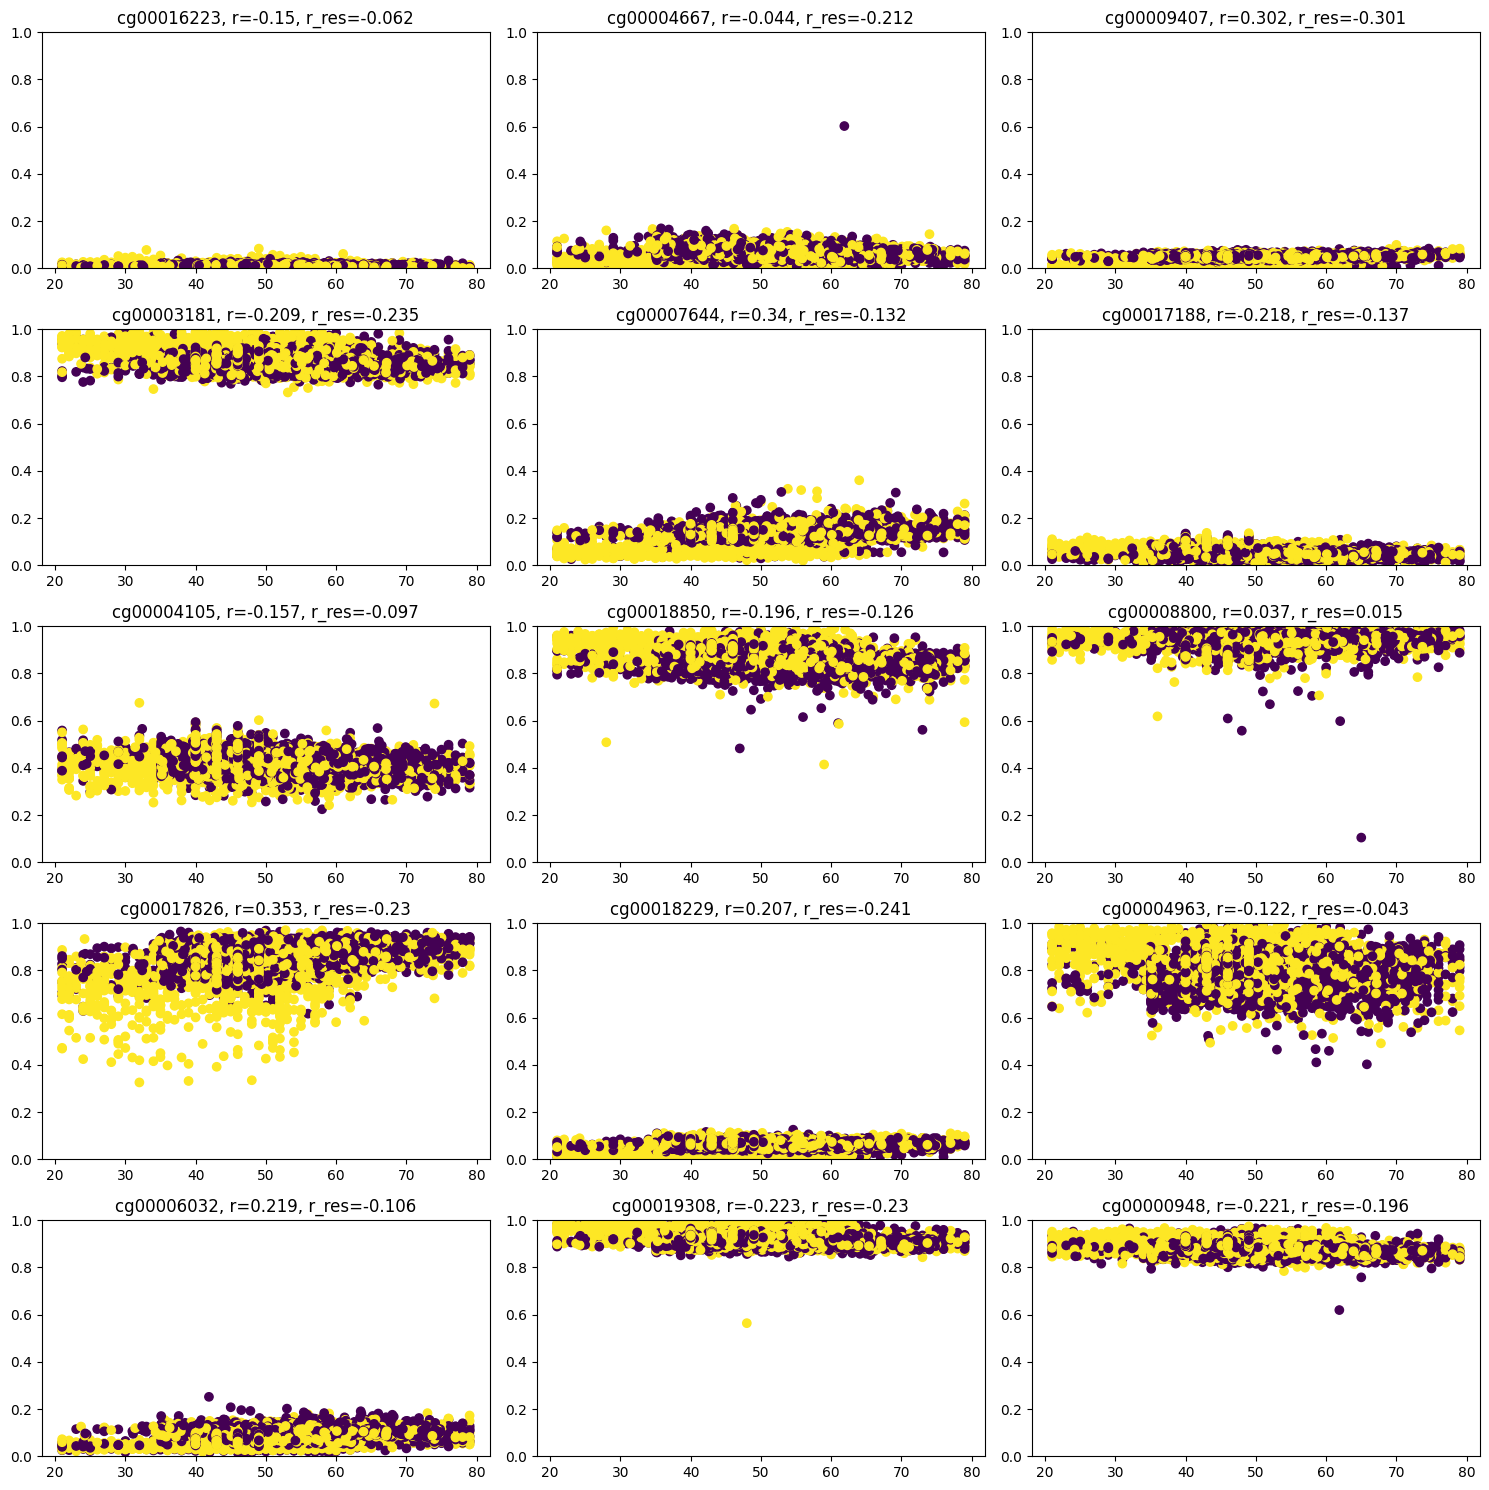

In [45]:
nsamples = 15

choice = np.random.choice(topsites, nsamples, replace=False)

fig, axs = plt.subplots(5, 3, figsize=(15, 15))
# Iterate over the columns and create a boxplot for each one
for i, col in enumerate(choice):
    ax = axs[i // 3, i % 3]
    ax.scatter(meta['Age'], data[col], c=meta['Gender'].map({'M':0, 'F':1}))
    ax.set_ylim([0, 1])
    r = stats.loc[col, 'rvalue']
    r_res = stats.loc[col, 'r_res']
    ax.set_title(f'{col}, r={round(r, 3)}, r_res={round(r_res, 3)}')
    # Adjust the layout and show the plot
plt.tight_layout()
plt.show()
